In [1]:
import numpy as np
from umap import UMAP

from torch import no_grad, flatten
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
path_to_image_folder = '~/art/datasets/'
batch_size = 128

In [3]:
# https://github.com/lukemelas/EfficientNet-PyTorch
model = EfficientNet.from_pretrained('efficientnet-b2', )

Loaded pretrained weights for efficientnet-b2


In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths
    from https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [5]:
# imagenet preprocessing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
dataset = ImageFolderWithPaths(path_to_image_folder,
    transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

In [6]:
val_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

In [7]:
all_processed_image_paths = []
all_features = []

# iterate through batches and transform image into feature vector
with no_grad():
    for i, (images, target, paths) in enumerate(val_loader):
        if i == 0:
            print('Converting images to features...')

        features = model.extract_features(images)
        flat_features = flatten(features, start_dim=1).detach().numpy()
        
        all_features.append(flat_features)
        all_processed_image_paths.extend(paths)
        print(f'Featurized batch #{i} - {min(((i+1)*batch_size) / len(dataset),1.0)}')

Converting images to features...
Featurized batch #0 - 0.0652395514780836
Featurized batch #1 - 0.1304791029561672
Featurized batch #2 - 0.19571865443425077
Featurized batch #3 - 0.2609582059123344
Featurized batch #4 - 0.32619775739041795
Featurized batch #5 - 0.39143730886850153
Featurized batch #6 - 0.4566768603465851
Featurized batch #7 - 0.5219164118246687
Featurized batch #8 - 0.5871559633027523
Featurized batch #9 - 0.6523955147808359
Featurized batch #10 - 0.7176350662589195
Featurized batch #11 - 0.7828746177370031
Featurized batch #12 - 0.8481141692150866
Featurized batch #13 - 0.9133537206931702
Featurized batch #14 - 0.9785932721712538
Featurized batch #15 - 1.0


In [8]:
X = np.concatenate(all_features)

In [9]:
print(X.shape)
print(len(all_processed_image_paths))

(1962, 68992)
1962


In [10]:
# # ... image preprocessing as in the classification example ...
# print(images.shape) # torch.Size([1, 3, 224, 224])

# # https://github.com/lukemelas/EfficientNet-PyTorch#example-feature-extraction
# features = model.extract_features(images)
# print(features.shape) # torch.Size([1, 1280, 7, 7]) --> flattened into 62720

In [11]:
# reduce 62720 dimensions to 2 dimensions
reducer = UMAP(n_components=2)

In [12]:
embed = reducer.fit_transform(X)

In [13]:
def getImage(path):
    return OffsetImage(plt.imread(path), zoom=0.015)

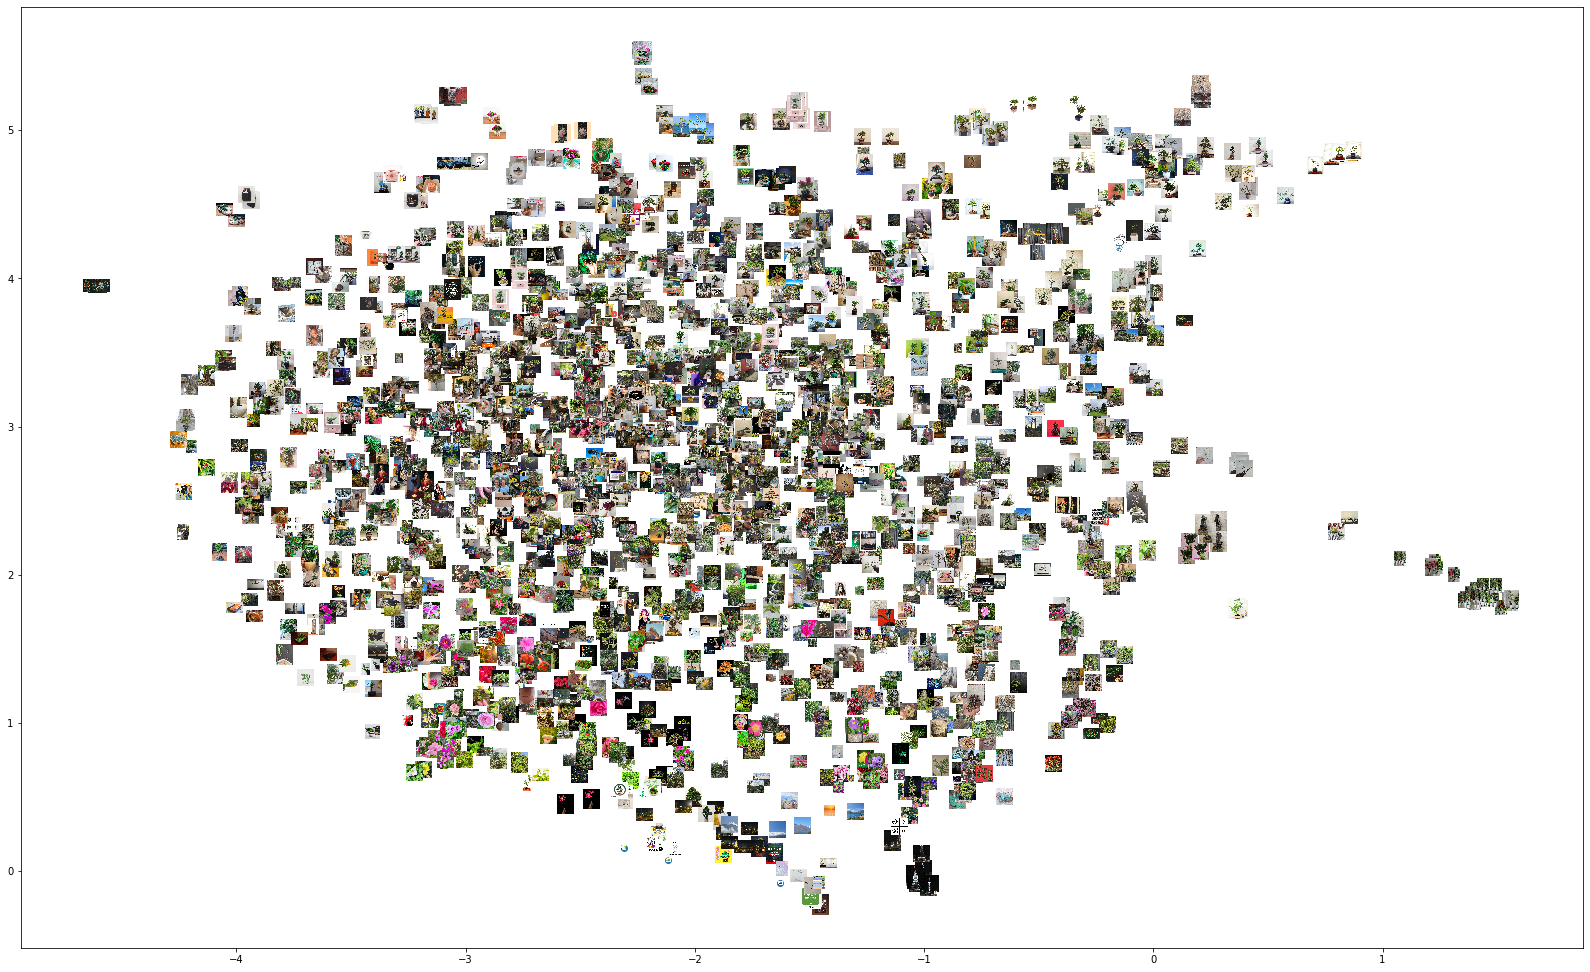

In [14]:
# plot the projected images, with thumbnails over their position in latent space
fig, ax = plt.subplots(figsize=(28, 28/1.618))

ax.scatter(embed[:,0], embed[:,1]) 

for x0, y0, path in zip(embed[:,0], embed[:,1], all_processed_image_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)